## Imports

In [1]:
#List of imports

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from hmmlearn import hmm

import urllib.request
import zipfile
import cvxpy as cp
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import itertools
import random

random.seed(50)

## Additions below
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
from tqdm.notebook import tqdm
import warnings; warnings.simplefilter('ignore')

# Main Final

In [ ]:
##Main


#Set up Data
price_data = pd.read_csv("../Data/small_universe.csv", index_col='Date').fillna(method="bfill")
rf = price_data["10 YR"]
universe=['ETN', 'AME', 'AAL', 'CHRW', 'ABT', 'AMGN', 'VRTX', 'ALGN', 'AAPL', 'ADBE', 'AMD', 'ADS', 'T', 'CMCSA', 'ATVI', 'CHTR', 'AMZN', 'F', 'DG', 'CMG', 'DUK', 'LNT', 'AES', 'FE', 'C', 'BAC', 'CBOE', 'RE', 'APD', 'FMC', 'BLL', 'CF', 'DRE', 'BXP', 'EQIX', 'CCI', 'CL', 'KMB', 'KR', 'STZ', 'CVX', 'XOM', 'COG', 'APA']
data = Data(price_data, rf,universe, "FF")

#Set up Portfolio
port=Portfolio(data)

#Set up Variables
num_stocks=data.get_num_stocks()
start_date = "2007-12-31"
end_date = "2020-11-26"
#1 year lookback
lookback = 12 
lookahead = 1
annual_ret=0.1
lam = (1+annual_ret)**(1/12)-1
trans_coeff = 0.01
holding_coeff = 0.01
conf_level = 0.1


#Set up constraints
constr_list = ["asset_limit_cardinality"]
constr_model = Constraints(constr_list)

#Set up cost models
cost_model = Costs(trans_coeff, holding_coeff)
cost_model.replicate_cost_coeff(num_stocks, lookahead)

opt_model = Model(lookahead,lam)
risk_model = Risks("ellip", conf_level)

regress_weighting = [0,0.3,0.3,0.4]
factor_model = FactorModel(lookahead, lookback, regress_weighting)

back_test = Backtest(start_date, end_date)
back_test.run(data, port, factor_model, opt_model, constr_model, cost_model, risk_model)


port return: 0.0391
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0367
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0371
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0345
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0377
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0408
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0399
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0399
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0379
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0385
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.04
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.0272
return_adj: 0
risk value: 0
holding cost: 0.0
trans cost: 0.0
port return: 0.021

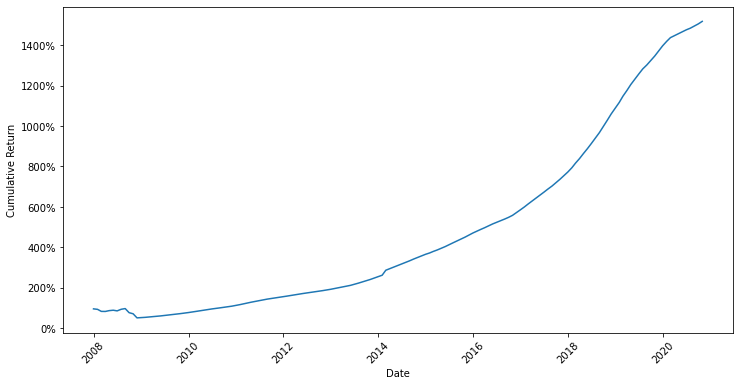

In [51]:
port.plot()

## Class Definitions Data/Portfolio


In [53]:
class Data:
    #Anything Data Related
    def __init__(self, stock_prices, risk_free, universe=None,factor_type='PCA', period='M'):
        #TO-DO: Add initialization of market cap
        
        if not universe:
            universe = stock_prices.columns
            
        if type(universe[0]) == int:
            self.stock_prices = stock_prices.iloc[:,universe]

        else:
            self.stock_prices = stock_prices[universe]
        
        self.risk_free = risk_free
        self.risk_free.index = pd.to_datetime(self.risk_free.index)
        self.risk_free = self.risk_free.resample(period).last()
        self.stock_prices.index= pd.to_datetime(self.stock_prices.index)
        self.stock_returns=self.get_stock_returns(period)
        self.factor_returns= self.get_factor_returns(factor_type)
 
        return
    
    def get_stock_returns(self, period='M'):
        price = self.stock_prices.resample(period).last()

        # Calculate the percent change
        ret_data = price.pct_change()[1:]

        # Convert from series to dataframe
        ret_data = pd.DataFrame(ret_data)

        return ret_data

    def get_factor_returns(self, factor_type='PCA', period='M'):
        if factor_type == 'CAPM':
         
            return self.get_CAPM_returns(period)
        
        elif factor_type == 'FF':
       
            return self.get_FF_returns(period)
            
        elif factor_type == 'Carhart':
           
            return self.get_Carhart_returns(period)
            
        elif factor_type == 'PCA':
           
            return self.get_PCA_returns(period)
        
        else:
            print("Invalid input: Please select one of the following factor types: CAPM, FF, Carhart or PCA.")
        
        return   
    
    def get_FF_returns(self, period='M'):
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"    
        # Download the file and save it  
        urllib.request.urlretrieve(ff_url,'fama_french.zip')
        zip_file = zipfile.ZipFile('fama_french.zip', 'r')    
        # Extact the file data
        zip_file.extractall()
        zip_file.close()    
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)   
        # Skip null rows
        ff_row = ff_factors.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)

        # Format the date index
        ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')

        # Format dates to end of month
        ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

        # Resample the data to correct frequency
        ff_factors = ff_factors.resample(period).last()

        # Convert from percent to decimal
        ff_factors = ff_factors.apply(lambda x: x/ 100)

        return ff_factors
    
    def get_CAPM_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)
        
        # Remove the unnecessary factors
        capm_factors = ff_factors.iloc[:, 0]
        
        return capm_factors
    
    def get_Carhart_returns(self, period='M'):
        ff_factors = self.get_FF_returns(period)

        # Get the momentum factor
        momentum_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"

        # Download the file and save it  
        urllib.request.urlretrieve(momentum_url,'momentum.zip')
        zip_file = zipfile.ZipFile('momentum.zip', 'r')

        # Extact the file data
        zip_file.extractall()
        zip_file.close()

        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0)

        # Skip null rows
        row = momentum_factor.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, nrows = row, index_col = 0)

        # Format the date index
        momentum_factor.index = pd.to_datetime(momentum_factor.index, format= '%Y%m')

        # Format dates to end of month
        momentum_factor.index = momentum_factor.index + pd.offsets.MonthEnd()

         # Resample the data to correct frequency
        momentum_factor = momentum_factor.resample(period).last()

        # Convert from percent to decimal
        momentum_factor = momentum_factor.apply(lambda x: x/ 100)

        # Combine to create the carhart_factors
        carhart_factors = pd.concat([ff_factors, momentum_factor], axis=1).dropna()

        return carhart_factors
    
    def get_PCA_returns(self, period='M'):
        exRets = self.get_stock_returns(period="D")
        num_stocks = len(exRets.columns)
        returns_mat = exRets.to_numpy()
        n_dates = returns_mat.shape[0]
        n_assets = returns_mat.shape[1]
        
        demeaned = (returns_mat - returns_mat.mean(axis=0)).transpose()
        sigma = 1/(n_dates - 1)*np.matmul(demeaned,demeaned.transpose())
        eigval, eigvec = np.linalg.eig(sigma)
        
        principal_components = np.matmul(eigvec.transpose(),demeaned).transpose()
        pca_factors = np.real(principal_components[:,0:100])
        
        pca_df = pd.DataFrame(pca_factors, index = exRets.index, columns = [str(i) for i in range(num_stocks)])
        pca_df = pca_df.resample(period).last()
        
        return pca_df
    
    def get_index_from_date(self, date_index_df, date):
        return date_index_df.index.get_loc(date)
    
    def get_lookback_data(self, date_index_df, date, lookback):
        end_idx= self.get_index_from_date(date_index_df, date)
        return date_index_df.iloc[end_idx-lookback:end_idx]      
    
    def get_num_stocks(self):
        return len(self.stock_returns.columns)

    
class Portfolio:
    #Anything Portfolio related: weights, returns, date-stamped
    def __init__(self, data):       
        num_stocks=data.get_num_stocks()
        self.weights= np.array([[0]*num_stocks + [1]]) # 0 weight on stock
        self.returns= np.array([])
        self.dates= []
        return
        
    def update_weights(self, new_weights):
        
        new_weights = np.expand_dims(new_weights, axis=0)
        self.weights = np.append(self.weights, new_weights, axis=0)
        return
     
    def update_returns(self, new_returns):
        self.returns=np.append(self.returns, new_returns)
        return

    def update_dates(self, new_dates):
       
        self.dates.append(new_dates)
        return
        
    def get_Sharpe(self, data):
        risk_free = data.risk_free
        recent_date = self.dates[-1]
        sigma = np.std(self.returns - np.array(risk_free.loc[self.dates]))
        sharpe_ratio = ((np.prod(1+self.returns)-1) - np.array(risk_free.loc[recent_date]))/sigma
        return sharpe_ratio
        
    def plot(self):
        port_cumu_returns = np.array([x+1 for x in self.returns]).cumprod()
        plt.figure(figsize=(12,6))
        plt.plot(self.dates, port_cumu_returns)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.show()
    


## Class Definitions: Cost/Constraints

In [54]:
class Costs:
    def __init__(self, trans_coeff, holding_coeff):
        self.holding_cost = 0
        self.trans_cost = 0
        self.trans_coeff = trans_coeff
        self.holding_coeff = holding_coeff
        return
        
    def replicate_cost_coeff(self, num_stocks, lookahead):
        trans_cost_repl = np.ones((num_stocks,lookahead))
        holding_cost_repl = np.ones((num_stocks, lookahead))
        self.trans_coeff = trans_cost_repl*self.trans_coeff
        self.holding_coeff = holding_cost_repl*self.holding_coeff
        return
    
    def set_holding_cost(self, weights_new):
        self.holding_cost += cp.sum(cp.multiply(self.holding_coeff, cp.neg(weights_new)))
        return
        
    def calc_trans_cost(self, weights_new, weights_old, trans_coeff):
        abs_trade= cp.abs(weights_new-weights_old)
        return cp.sum(cp.multiply(trans_coeff, abs_trade))       
    
    
    def set_trans_cost(self, weights_new, weights_old):
        weights_curr= weights_new[:,0]
        if weights_new.shape[1]>1:         
            weights_future = weights_new[:,1:]
            weights_future_shift = weights_new[:,:-1]
            self.trans_cost = self.calc_trans_cost(weights_future, weights_future_shift, self.trans_coeff[:,1:])

        self.trans_cost += self.calc_trans_cost(weights_curr, weights_old,self.trans_coeff[:,0])
        return


class Constraints:
        #List of all constraints
        def __init__(self, constr_list=['asset_limit_cardinality'], 
                     upper_limit=0.20, lower_limit=-0.20, stock_limit=15):
            self.upper_limit = upper_limit
            self.lower_limit = lower_limit
            self.stock_limit = stock_limit
            self.constr_list = constr_list
            self.value=[]

        
        def set_constraints(self, all_weights, y, cvar=False, gamma=None, z=None, r=None):
            
            # weights is without risk free
            weights=all_weights[:-1,:]
       
            #unity condition
            self.value += [cp.sum(all_weights,axis=0)==1]
            
            #can never be short cash
            self.value += [all_weights[-1,:]>=0]
            
            num_stocks=weights.shape[0]
            
            if cvar:
                self.value += [z >= 0]
                self.value += [z >= -r.T@all_weights-gamma]
            
            if "no_short" in self.constr_list:
                self.value+=  [weights>=0]
                
            if "asset_limit_cardinality" in self.constr_list:
                upper_limit= cp.multiply(self.upper_limit, y)
                lower_limit = cp.multiply(self.lower_limit,y)
                
                #ensure that at least 1 but no more than 2 in each sector
                for i in range(0,num_stocks,4):
                    self.value += [y[i:i+3]>=1]
                   # self.value += [y[i:i+3]<=2]
                    
                self.value += [weights>=lower_limit, weights<=upper_limit]

            elif "asset_limit" in self.constr_list:
                self.value += [weights>=self.lower_limit, weights<=self.upper_limit]
        
            return



    


## Class Definitions Risk Type/ Optimization Models

In [55]:
class Risks:
    def __init__(self, risk_type="MVO", robust_type="ellip", conf_lvl=0):
        #risk value, return adjustment, risk type and confidence level
        self.value=0
        self.return_adj=0
        self.risk_type=risk_type
        self.robust_type=robust_type
        self.conf_lvl=conf_lvl
        return
        
    def set_risk(self, weights, Q, lookahead=1, S=5000, gamma=None, z=None, alpha=None):
        
        portfolio_risk=0
        robustness_cost=0
        num_stocks = weights.shape[1]
        
        if self.risk_type== "MVO":
        
            for i in range(lookahead):
                portfolio_risk += cp.quad_form(weights[:,i], Q[i])        
            self.value = portfolio_risk
            
        elif self.risk_type == "CVAR":
            if not S or not gamma or not z or not alpha:
                print("Missing one of these required inputs for CVaR optimization: S, gamma, z, alpha")
                return
            self.value = gamma + (1/((1-alpha)*S))*cp.sum(z)
        
        if self.robust_type == "rect":
            
            for i in range(lookahead):
                delta = stats.norm.ppf(self.conf_lvl)*np.sqrt(np.diag(Q[i]/num_stocks))
                robustness_cost += delta@cp.abs(weights[:,i])
            self.return_adj= robustness_cost
        
        elif self.robust_type == "ellip":
            
            for i in range(lookahead):
         
                penalty = cp.norm(np.sqrt(np.diag(Q[i]/num_stocks))@weights[:,i],2)
                robustness_cost += stats.chi2.ppf(self.conf_lvl, num_stocks)*penalty
            self.return_adj = robustness_cost
            
    
        return

    def get_RP_objective(self, weights, args):
        Q = args[0]
        assets_risk_budget = args[1]
        lookahead = args[2]
        cost_model = args[3]
        
        num_stocks = len(assets_risk_budget)

        self.value=0
        # We convert the weights to a matrix
        weights = np.matrix(weights)
        for i in range(lookahead):
            # We calculate the risk of the weights distribution

            portfolio_risk = np.sqrt((weights[0,num_stocks*i:num_stocks*(i+1)] * Q[i] 
                                      * weights[0,num_stocks*i:num_stocks*(i+1)].T))[0, 0]

            # We calculate the contribution of each asset to the risk of the weights
            # distribution
            assets_risk_contribution = np.multiply(weights[0,num_stocks*i:num_stocks*(i+1)].T, Q[i] 
                                                   * weights[0,num_stocks*i:num_stocks*(i+1)].T)/ portfolio_risk

            # We calculate the desired contribution of each asset to the risk of the
            # weights distribution
            assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

            # Error between the desired contribution and the calculated contribution of
            # each asset
            self.value += np.sum(np.square(assets_risk_contribution - assets_risk_target.T))
            
            # Get the holding costs
            self.value += np.sum(cost_model.holding_coeff[0,0]*weights[0,num_stocks*i:num_stocks*(i+1)])
            
            # Get the transaction costs
            if i < lookahead-1:
                abs_trade = np.abs(weights[0, num_stocks*i:num_stocks*(i+1)]-
                                   weights[0, num_stocks*(i+1):num_stocks*(i+2)])
                self.value += np.sum(cost_model.trans_coeff[0,0]*abs_trade)
            
        # It returns the calculated error
        return self.value 
    
    
    
class Model:
    def __init__(self, look_ahead, goal_ret):
        self.opt_weights = 0
        self.status = None
        self.look_ahead=look_ahead
        self.goal_ret=goal_ret
        return
        
    def Solver(self, port, mu , Q, rf, constr_model, cost_model, risk_model, scen_model=None):
        
        mu_np = np.array(mu)
        Q_np = np.array(Q)        
        num_stocks = port.weights.shape[1]-1
        num_simulations=5000
        
        if risk_model.risk_type =="CVAR":
            self.look_ahead=1
            mu_np = np.array(mu)[0,:]
            mu_np = np.expand_dims(mu_np, axis=0)
        
        
        #Construct optimization problem
        all_weights = cp.Variable((num_stocks+1,self.look_ahead))   
        y = cp.Variable((num_stocks,self.look_ahead), boolean=True)
        z = cp.Variable((num_simulations,1)) 
        g = cp.Variable(1) 
        
        weights_prev= port.weights[-1,:-1]   
        weights=all_weights[:-1,:]

        # Set model parameters
        cost_model.set_trans_cost(weights, weights_prev)
        cost_model.set_holding_cost(weights)    
        constr_model.set_constraints(all_weights, y)
        #scen_model.set_scenarios()
        
        if risk_model.risk_type=="CVAR":
            constr_model.set_constraints(all_weights, y, cvar=True, gamma=g, z=z, r=scen_model.value)
            risk_model.set_risk(weights, Q, S=5000, gamma=g, z=z, alpha=alpha)
        elif risk_model.risk_type=="MVO":        
            constr_model.set_constraints(all_weights, y)
            risk_model.set_risk(weights, Q, self.look_ahead)

        # Get portfolio return
        portfolio_return_per_period = mu_np@weights
        rf_return = cp.sum(rf*all_weights[-1,:])
        portfolio_return = cp.trace(portfolio_return_per_period)+rf_return 
        
        #Max return objective
        #objective= cp.Maximize(portfolio_return-risk_model.return_adj)
        
        #Minimize risk objective
        objective= cp.Minimize(risk_model.value)
        constr_model.value+= [portfolio_return - risk_model.return_adj-cost_model.trans_cost -cost_model.holding_cost >=self.goal_ret]
        
        #Construct Problem and Solve
        prob= cp.Problem(objective, constr_model.value)
        result=prob.solve(solver="GUROBI")
        self.status= prob.status
        if self.status == "optimal":
            self.opt_weights=np.array(all_weights.value)[:,0]
            print("port return:",portfolio_return.value)
            print("return_adj:", risk_model.return_adj)
            print("risk value:",risk_model.value)
            print("holding cost:",cost_model.holding_cost.value)
            print("trans cost:", cost_model.trans_cost.value)
    
        else:
            print("Unsolvable, use old weights")
            self.opt_weights=port.weights[-1].T
     
        return self.opt_weights
    


    def risk_parity(self, port, Q, lookahead, risk_model, cost_model):
        TOLERANCE = 1e-7
        Q_np =np.array(Q)
        num_stocks=port.weights.shape[1]-1

        #Construct optimization problem
        init_weights = np.tile(port.weights[-1,:-1],lookahead).astype(float)
        init_rf = port.weights[-1,-1]
        weight_total = 1-init_rf
        
        if np.count_nonzero(init_weights)==0:
            init_weights = np.array([1/num_stocks]*num_stocks*lookahead)
            weight_total=1
            init_rf = 0
        
        # The desired contribution of each asset to the portfolio risk: we want all
        # assets to contribute equally
        assets_risk_budget = [1/num_stocks] * num_stocks

        # Optimisation process of weights
        # Restrictions to consider in the optimisation: only long positions whose
        # sum equals 100%
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - weight_total},
                       {'type': 'ineq', 'fun': lambda x: x})

        # Optimisation process in scipy
        optimize_result = minimize(fun=risk_model.get_RP_objective,
                                   x0=init_weights,
                                   args=[Q, assets_risk_budget, lookahead, cost_model],
                                   method='SLSQP',
                                   constraints=constraints,
                                   tol=TOLERANCE,
                                   options={'disp': False, 'maxiter':5000}
                                  )

        # Recover the weights from the optimised object
        weights = np.array(optimize_result.x) 
        
        self.opt_weights = np.concatenate((weights[0:num_stocks], np.array([init_rf])))
        return self.opt_weights        

 

## Class Definitions Backtest/Gridsearch

In [56]:
    
class Livetest:
    def __init__(self, start_date, end_date, period='M'):
        self.rebal_freq = period
        self.start_date = start_date
        self.end_date = end_date        

        return
        
    
    def run(self, data, portfolio):      
        look_back= factor_model.lookback
        look_ahead= factor_model.lookahead
        stock_return= data.stock_returns      
        reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)    
        
        
        for t in reb_dates:
            #need some dynamic adjustment here... how to set risk_model confidence level, cost_coefficieints,
            #constraint asset limits, goal_return ,, factor_model, opt_model, constr_model, cost_model, risk_model
            
            goal_return
            
            
            mu, Q = factor_model.get_param_estimate(t, data)
            new_rf_rate=float(data.risk_free.loc[t])            
            
            weights = opt_model.Solver(portfolio, mu , Q, new_rf_rate, self.lookahead,
                                        constr_model, cost_model, risk_model)     
            

#             elif risk_model.risk_type == 'risk-parity':
#                 weights = optimizer.risk_parity(portfolio, Q, self.lookahead, risk_model, cost_model)
                

                
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights[:-1],stock_return.loc[t])+weights[-1]*new_rf_rate)

        return portfolio.get_Sharpe(data)




In [57]:
    
class Backtest:
    def __init__(self, start_date, end_date, period='M'):
        self.rebal_freq = period
        self.start_date = start_date
        self.end_date = end_date        

        return
        
    
    def run(self, data, portfolio, factor_model, opt_model, constr_model, cost_model, risk_model):      
        look_back= factor_model.lookback
        look_ahead= factor_model.lookahead
        stock_return= data.stock_returns      
        reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)    

        
        for t in reb_dates:
            
            
            mu, Q = factor_model.get_param_estimate(t, data)
            new_rf_rate=float(data.risk_free.loc[t])            
            
            weights = opt_model.Solver(portfolio, mu , Q, new_rf_rate, constr_model, cost_model, risk_model)     
            

#             elif risk_model.risk_type == 'risk-parity':
#                 weights = optimizer.risk_parity(portfolio, Q, self.lookahead, risk_model, cost_model)
                

                
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights[:-1],stock_return.loc[t])+weights[-1]*new_rf_rate)

        return portfolio.get_Sharpe(data)


    def grid_search(self, data, portfolio, model, trans_coeff=0.2, hold_coeff=0.2, lam=0.9, conf_level=0.95):

#         # Overall - currently test values are used
#         pot_lookaheads = [1, 3, 6, 12, 60]
#         pot_lookbacks = [2, 3, 6, 12, 60]

#         # Factor Models
#         factor_models = ['CAPM', 'FF', 'Carhart', 'PCA'] # Data
#         regressions = ['linear', 'lasso', 'ridge', 'SVR'] # FactorModel

#         # Constraints
#         cardinalities = ['', 'cardinality']
#         asset_limits = ['asset_limit_cardinality', 'asset_limit']
#         no_shorts = ['', 'no_short']
#         constraints_list = [cardinalities, asset_limits, no_shorts]

#         stock_limits = list(range(5, 501, 5))

#         # Optimization
#         MVO_robustness = ['', 'rectangular', 'elliptical']

        # Overall
        pot_lookaheads = [5]
        pot_lookbacks = [20]

        # Factor Models
        factor_models = ['FF', 'PCA']  # Data
        weights = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[0.25,0.25,0.25,0.25],
                       [0,0.5,0.5,0],[0,0.25,0.25,0.5],[0,0,0.5,0.5]]

        # Constraints
        cardinalities = ['cardinality']
        asset_limits = ['asset_limit_cardinality', 'asset_limit']
        no_shorts = ['no_short']
        constraints_list = [cardinalities, asset_limits, no_shorts]

        stock_limits = list(range(5, 21, 5))
        upper_asset_limits = [1]
        lower_asset_limits = [-1]

        # Optimization
        MVO_robustness = ['ellip']

        # list of sharpe ratios per parameter combination
        sharpe_ratios = []

        # list of parameter combinations corresponding to sharpe ratio
        parameter_combos = []

        for combo in tqdm(list(itertools.product(factor_models, weights, \
                                                 list(itertools.product(*constraints_list)), stock_limits, \
                                                 upper_asset_limits, lower_asset_limits, MVO_robustness))):

            # Store the combination
            curr_combo = {'rebalance_freq': 'M', 'factor_model': combo[0], 'weights': combo[1],
                          'constraints_list': list(combo[2]), 'stock_limit': combo[3], 'upper_asset_limit': combo[4],
                          'lower_asset_limit': combo[5], 'robustness': combo[6]}

            # Initial Setup
            data.set_factor_returns(curr_combo['factor_model'], curr_combo['rebalance_freq'])

            num_stocks = data.get_num_stocks()
            cost_model = Costs(trans_coeff, hold_coeff)

            # Get lookaheads that are multiples of the rebalancing frequency and <= 60 months
            if curr_combo['rebalance_freq'] == 'M':
                first = 1
            else:
                first = int(curr_combo['rebalance_freq'][0])

            lookaheads = list(itertools.compress(pot_lookaheads, [look >= first for look in pot_lookaheads]))
            lookbacks = list(itertools.compress(pot_lookbacks, [look >= first for look in pot_lookbacks]))

            for lookahead in lookaheads:
                curr_combo['lookahead'] = lookahead
                for lookback in lookbacks:
                    curr_combo['lookback'] = lookback

                    # Continue Setup
                    cost_model.replicate_cost_coeff(num_stocks, lookahead)
                    constr_model = Constraints(curr_combo['constraints_list'])

                    risk_model = Risks(curr_combo['robustness'], conf_level)

                    # Run backtest
                    factor = FactorModel(curr_combo['lookahead'], curr_combo['lookback'],
                                         curr_combo['weights'])
                    sharpe = self.run(data, portfolio, factor, model, constr_model, cost_model, risk_model)

                    # Update results
                    sharpe_ratios.append(sharpe)
                    parameter_combos.append(curr_combo)

        return sharpe_ratios, parameter_combos


## Factor Models

In [58]:
class FactorModel:
    def __init__(self, lookahead, lookback, regress_weighting):
        
        """
        lookahead: number of periods in the future to estimate
        lookback: number of periods in the past to use for estimations
        regress_weighting: array of size 4 with weight corresponding to each regression type; adds up to 1; 
        order is linear, lasso, ridge, SVR; in the case where there is one 1 and the rest 0's, there is no ensembling;
        can artifically call LSTM by setting all weights to 0
        """
        self.lookahead = lookahead
        self.lookback = lookback
        self.regress_weighting = regress_weighting
        return
               
    def get_param_estimate(self, rebal_date, data):
               
        if sum(self.regress_weighting) == 0:
            return self.get_mu_LSTM(rebal_date, data)

        elif sum(self.regress_weighting) == 1:
            return self.get_mu_Q_regression(rebal_date, data)
        
        else:
            return "ERROR: This regression weighting is not valid. Please make sure the weights sum to 1. You can also give all zeros for LSTM."
        
    def get_mu_Q_regression(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting
                
        # For keeping track of mu's and Q's from each period
        mu_arr = []
        Q_arr = []

        n_factors = len(factor_data.columns)
        


        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)

        
        
        for i in range(0, lookahead):

            # Calculate the factor covariance matrix

            F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()

            # Calculate the factor expected excess return from historical data using the geometric mean
            factor_data['Ones'] = [1 for i in range(len(factor_data))]
            gmean = stats.gmean(factor_data + 1,axis=0) - 1

            # Set up X and Y to determine alpha and beta
            X = factor_data
            Y = returns_data
            X = X.to_numpy()
            Y = Y.to_numpy()
 
            ### LINEAR REGRESSION
        
            model = LinearRegression().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_linear = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_linear = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### LASSO REGRESSION

            model = Lasso().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_lasso = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_lasso = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### RIDGE REGRESSION

            model = Ridge().fit(X,Y)
            alpha = model.intercept_
            beta = model.coef_[:,0:n_factors]

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_ridge = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_ridge = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D


            ### SUPPORT VECTOR REGRESSION

            model = make_pipeline(StandardScaler(), MultiOutputRegressor(LinearSVR(C=1, dual=False, loss="squared_epsilon_insensitive"))).fit(X, Y)
            beta = np.array([[model.named_steps['multioutputregressor'].estimators_[i].coef_[0:n_factors] for i in range(len(model.named_steps['multioutputregressor'].estimators_))]])[0]
            alpha = np.array([model.named_steps['multioutputregressor'].estimators_[i].intercept_[0] for i in range(len(model.named_steps['multioutputregressor'].estimators_))])

            # Calculate the residuals 
            alpha = np.reshape(alpha,(alpha.size,1))
            epsilon = returns_data.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

            # Calculate the residual variance with "N - p - 1" degrees of freedom
            sigmaEp = np.sum(epsilon**2, axis=0) / (len(returns_data) - n_factors - 1)

            #  Calculate the asset expected excess returns
            mu_SVR = model.predict([gmean])[0]

            # Calculate the diagonal matrix of residuals and the asset covariance matrix
            D = np.diag(sigmaEp)

            # Calculate the covariance matrix
            Q_SVR = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

        
            # Ensemble the methods
            mu = regress_weighting[0]*mu_linear + regress_weighting[1]*mu_lasso + regress_weighting[2]*mu_ridge + regress_weighting[3]*mu_SVR
            Q = regress_weighting[0]*Q_linear + regress_weighting[1]*Q_lasso + regress_weighting[2]*Q_ridge + regress_weighting[3]*Q_SVR

            # Add mu and Q to array
            mu_arr.append(mu)
            Q_arr.append(Q)

            # Update for next time step
            factor_data = factor_data[1:]
            factor_append = pd.Series(gmean, index = factor_data.columns)
            factor_data = factor_data.append(factor_append, ignore_index=True)

            returns_data = returns_data[1:]
            mu_append = pd.Series(mu, index=returns_data.columns)
            returns_data = returns_data.append(mu_append, ignore_index=True)   

        return mu_arr, Q_arr
        
    def get_mu_LSTM(self, rebal_date, data): 
        returns_data = data.stock_returns
        factor_data = data.factor_returns
        
        lookahead = self.lookahead
        lookback = self.lookback
        regress_weighting = self.regress_weighting

        returns_data = data.get_lookback_data(returns_data, rebal_date, lookback)
        factor_data = data.get_lookback_data(factor_data, rebal_date, lookback)
        
        tempx, tempy = self.generate_X_y(factor_data.values, returns_data.values, lookback, lookahead)
        train_x, test_x, train_y, test_y = self.traintest_split(tempx, tempy)

        # scale inputs
        scaled_train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())
        scaled_test_x = (test_x - test_x.min())/(test_x.max() - test_x.min())
        scaled_train_y = (train_y - train_y.min())/(train_y.max() - train_y.min())
        scaled_test_y = (test_y - test_y.min())/(test_y.max() - test_y.min())

        mu = self.get_prediction(train_x, train_y, factor_data, lookback)
        return mu
    
    def generate_X_y(self, factor_data, returns_data, n_lookback, n_lookforward):
        X, y = list(), list()
        in_start = 0
        for i in range(len(factor_data)):
            in_end = in_start + n_lookback
            out_end = in_end + n_lookforward
            # ensure we have enough data for this instance
            if out_end <= len(factor_data):
                X.append(factor_data[in_start:in_end,:])
                y.append(returns_data[in_end:out_end,:])
            in_start += 1
        return np.array(X), np.array(y)
    
    def traintest_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test   
    
    def build_model(self, train_x, train_y):
        # define parameters
        verbose, epochs, batch_size = 0, 50, 16
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # define model
        model = Sequential()
        model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(200, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(100, activation='relu')))
        model.add(TimeDistributed(Dense(train_y.shape[2])))
        model.compile(loss='mse', optimizer='adam')
        # fit network
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return model
    
    def forecast(self, model, history, n_lookback):
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for lookback data
        input_x = data[-n_lookback:, :]
        # reshape into [1, n_lookback, n]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
        # forecast the next set
        yhat = model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def evaluate_forecasts(self, actual, predicted):
        # calculate overall RMSE
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                for k in range(actual.shape[2]):
                    s += (actual[row, col, k] - predicted[row, col, k])**2
        score = sqrt(s / (actual.shape[0] * actual.shape[1] * actual.shape[2]))
        return score

    def evaluate_model(self, train_x, train_y, test_x, test_y, n_lookback):
        # fit model
        model = self.build_model(train_x, train_y)
        history = [x for x in train_x]
        # walk-forward validation 
        predictions = list()
        for i in range(len(test_x)):
            yhat_sequence = self.forecast(model, history, n_lookback)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next set
            history.append(test_x[i, :])
        # evaluate predictions 
        predictions = np.array(predictions)
        score = self.evaluate_forecasts(test_y, predictions)
        plt.plot(model.history.history['loss'])
        #plt.plot(model.history.history['val_loss'])
        return score
    
    def get_prediction(self, train_x, train_y, factor_data, lookback):
        model = self.build_model(train_x, train_y)
        return self.forecast(model, factor_data.tail(lookback), lookback)


### HMM Investigation

In [59]:
    
class Regime:
    def __init__(self, data ,t):
        train_prices=None
        train_returns=None
        train_dates=None
        self.get_train_data(data,t)

    def get_train_data(self, data, t):
        mkt_data = data.factor_returns["Mkt-RF"]+data_set.factor_returns["RF"]
        first_date="2010-01-01"
        mkt_returns=mkt_data[first_date:t]
        self.train_dates=mkt_returns.index

        mkt_returns=np.array(mkt_returns.values)
        mkt_prices = 100*(np.array([x+1 for x in mkt_returns]).cumprod())
        mkt_prices=np.expand_dims(mkt_prices,axis=1)
        mkt_returns=np.expand_dims(mkt_returns,axis=1)
        self.train_prices=mkt_prices
        self.train_returns=mkt_returns


    def HMM (self, num_hs):
        model=hmm.GaussianHMM(n_components=num_hs)
        model.fit(self.train_returns)
        return model

In [60]:
t="2019-12-31"
reg=Regime(data_set,t)
reg_model =reg.HMM(2)

NameError: name 'data_set' is not defined

In [ ]:
out=reg_model.predict(reg.train_returns)
test=np.array(list(map(bool,out)))

In [ ]:

        plt.figure(figsize=(12,6))
        plt.scatter(reg.train_dates[test],reg.train_prices[test])
        plt.scatter(reg.train_dates[~test],reg.train_prices[~test])

        plt.xticks(rotation=45)
        #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")